# Problem Statment:
Building a classifier to detect the brain tumor (if any) form the MRI scan images. By nowit is evident that this is a binary classification problem.

1) Dataset:Brain trumor dataset
2) Approach: Explotray data anaysis, Build CNN model, Train and Evalute model on dataset

In [1]:
from imutils import paths # generator function that search in a folder and finds only image files and all subfolders
import matplotlib.pyplot as plt
import argparse # command-line argument
import os
import cv2
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.metrics import AUC
from tensorflow.keras import regularizers
random.seed(42)
np.random.seed(42)
tf.keras.utils.set_random_seed(42)

2025-09-12 22:59:35.846943: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#load image directories
#we have one folder 

path="/Users/temp_user/ml/ComputerVision/medicalImageClassification/datasets/brain/brain_tumor_dataset"
image_paths=list(paths.list_images(path)) # creating full list of paths
image_paths[0]

'/Users/temp_user/ml/ComputerVision/medicalImageClassification/datasets/brain/brain_tumor_dataset/no/30 no.jpg'

In [3]:
# Itrate over each of path and extract dictionary name (yes or no) and resize image size to 224*224 pixels.
# imread function in cv2 convert image to pixel

images=[]
labels=[]

for image_path in image_paths:
    label=image_path.split(os.path.sep)[-2] # os.path.sep = the separator (/ on Mac/Linux, \ on Windows)
    image=cv2.imread(image_path) # read image into memory as a numpay array(rows,cols,channels) 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # VGG16 preprocess_input expects RGB, openCV loads BGR
    image=cv2.resize(image,(224,224))
    
    images.append(image)
    labels.append(label)


'no'

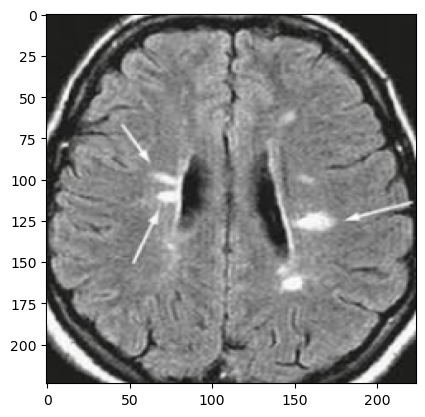

In [4]:
# plot on image
def plot_image(image):
    plt.imshow(image)

plot_image(images[0])
# print label: our lables are string
labels[0]

In [5]:
print(len(images))
print(len(labels))

253
253


In [6]:
# number of yes labes
def find_yes_labels(labels):
    yes_indices = [i for i, label in enumerate(labels) if label == "yes"]
    return yes_indices
print(len(find_yes_labels(labels)))

155


In [7]:
# number of no labels
def find_no_labels(labels):
    no_indices = [i for i, label in enumerate(labels) if label == "no"]
    return no_indices
print(len(find_no_labels(labels)))

98


In [8]:
# as our lable are string we need convert it to binary and then one hot vectors for neural network

from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
import numpy as np

# convert images and labels to numpy array for split dataset
images = np.array(images, dtype='float32')
labels = np.array(labels)

# it converts categorical labels (like "yes"/"no") into numbers (0/1)
label_binarizer = LabelBinarizer()
labels = label_binarizer.fit_transform(labels)

# converts numeric labels into one-hot vectors for netural network
# neural networks don’t just expect a single number as the target — they expect a probability distribution across all classes
labels=to_categorical(labels)
print(labels[0])

[1. 0.]


In [9]:
# split dataset to train, val and test set
from sklearn.model_selection import train_test_split

# With stratify=labels, First split: train (70%) and temp (30%)
x_train ,x_temp, y_train_onehot, y_temp_onehot=train_test_split(images,labels,test_size=0.30,random_state=42,stratify=labels)


In [10]:
# Second split: validation (15%) and test (15%)
x_val, x_test, y_val_onehot, y_test_onehot = train_test_split(
    x_temp, y_temp_onehot, 
    test_size=0.50,   
    stratify=y_temp_onehot,
    random_state=42
)

In [11]:
# y is 2d array
print(y_train_onehot.shape)
print(x_train.shape)

(177, 2)
(177, 224, 224, 3)


In [12]:
print(y_test_onehot.shape)
print(x_test.shape)

(38, 2)
(38, 224, 224, 3)


In [13]:
print(y_val_onehot.shape)
print(x_val.shape)

(38, 2)
(38, 224, 224, 3)


### Bulid CNN Model
1) Data augmentation: as our dataset is very small
2) Transfer learning VGG16 state_of_the_art network model
   VGG16: 224*224*3
I use VGG16 because it’s a proven, simple, and effective transfer learning model for small datasets, especially when starting out. But in production or research, people often switch to ResNet or EfficientNet for better accuracy and efficiency.

Model :
1) Feature extractor: VGG16 (frozen or fine-tuned).
2) Classifier head

In [14]:
# remove last layer of VGG16 and add our layers 
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,BatchNormalization
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False

x = base_model.output           # ~7x7x512
x = GlobalAveragePooling2D()(x) # -> 512
x = BatchNormalization()(x)
x = Dense(256, activation='relu',kernel_regularizer=regularizers.l2(1e-4))(x)
x = Dropout(0.5)(x)

out = Dense(1, activation='sigmoid')(x)  
model = Model(inputs=base_model.input, outputs=out)


In [15]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           25

 Total params: 14,848,321 (56.64 MB)

 Trainable params: 132,609 (518.00 KB)

 Non-trainable params: 14,715,712 (56.14 MB)

In [16]:
# Computing Class Weights
# our y_train is 2d array for class_weight we need 1d array
from sklearn.utils import shuffle ,class_weight

y_train = np.asarray(y_train_onehot).argmax(axis=1).astype(int)
class_weights=class_weight.compute_class_weight(class_weight='balanced', 
                                                classes=np.unique(y_train), #returns the sorted, unique labels
                                                y=y_train)

#keras need a dic for class_weight
class_weights_dict = dict(enumerate(class_weights))

In [18]:
# combile the frozen VGG16 backbone with new classifier head into a single trainable model
# build the model and compile it using the Adam as optimizer with a learning rate of 0.001 and accuracy as metric
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

model.compile(optimizer= Adam(learning_rate= 1e-3), metrics= ['accuracy'],loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05))

In [20]:
# data augmentation on training set and use preprocess_input of VGG16 for having same images
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input

train_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input, # use preprocess_input of VGG16 so inputs match how VGG16 was trained
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    zoom_range=0.15,
    shear_range=0.1,
    brightness_range=[0.9, 1.1],
    fill_mode='nearest'
)

val_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

In [21]:
# Train and evaluate model
# for small data set batchsize between 8 to 32
# Larger batch = faster training but needs more memory.
# Smaller batch = slower training but can give slightly better accuracy.
batch_size=8
# we have binary classification that we should pass binary labels
y_train_bin = y_train_onehot.argmax(axis=1).astype('int32')
y_val_bin   = y_val_onehot.argmax(axis=1).astype('int32')
y_test_bin  = y_test_onehot.argmax(axis=1).astype('int32')  

train_flow = train_generator.flow(x_train, y_train_bin, batch_size=batch_size, shuffle=True)
val_flow = val_generator.flow(x_val, y_val_bin, batch_size=batch_size, shuffle=False)
test_flow = test_generator.flow(x_test, y_test_bin, batch_size=batch_size, shuffle=False)


In [22]:
print(y_train_bin.shape)
print(x_train.shape)

(177,)
(177, 224, 224, 3)


In [23]:
# patience=3 means: if val_accuracy doesn’t improve for 3 consecutive epochs, stop training.
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=3,
    restore_best_weights=True
)

In [24]:
lr_reduction = ReduceLROnPlateau(
    monitor='val_loss',
    patience=2,
    factor=0.5,
    min_lr=1e-6
)

In [25]:
history = model.fit(
    train_flow,
    epochs=20,
    validation_data=val_flow,
    callbacks=[early_stopping, lr_reduction],
    class_weight=class_weights_dict
)

/opt/anaconda3/envs/ai-ml/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.6949 - loss: 0.6939 - val_accuracy: 0.7632 - val_loss: 0.9786 - learning_rate: 0.0010
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8814 - loss: 0.3797 - val_accuracy: 0.7895 - val_loss: 1.0131 - learning_rate: 0.0010
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.8757 - loss: 0.4191 - val_accuracy: 0.7632 - val_loss: 1.0405 - learning_rate: 0.0010
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.8701 - loss: 0.4257 - val_accuracy: 0.8158 - val_loss: 0.9274 - learning_rate: 5.0000e-04
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9096 - loss: 0.3119 - val_accuracy: 0.8158 - val_loss: 0.8787 - learning_rate: 5.0000e-04
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8814 - loss: 0.3775 - val_accuracy: 0.8421 - val_loss: 0.8089 - learning_rate: 5.0000e-04
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9379 - loss: 0.2746 - va

In [27]:
val_loss, val_accuracy = model.evaluate(val_flow)
print(f'Val accuracy after initial training: {val_accuracy:.4f}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 793ms/step - accuracy: 0.8421 - loss: 0.8089
Val accuracy after initial training: 0.8421


# Evaluate model
1) accuracy on training and validation sets
2) Precision, Recall (Sensitivity), F1
3) Confusion Matrix

# Observation:
Training keeps improving( acc up, loss down)
Validation accuracy sits in (0.76-0.84) does not follow train acc.
validation loss is high even when val acc is okay.
so we have moderate overfitting 
        

# Fine tuning the model
it is a samll data set <2k images unfreeze block5 and dcreass learning rate

In [28]:
for layer in base_model.layers:
    layer.trainable = layer.name.startswith("block5")  # unfreeze only block5

In [29]:
model.compile(optimizer= Adam(learning_rate= 1e-5), metrics= ['accuracy'], loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05))

In [30]:
history_finetune = model.fit(
    train_flow,
    epochs=10,
    validation_data=val_flow,
    callbacks=[early_stopping, lr_reduction],
    class_weight=class_weights_dict
)

Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9153 - loss: 0.3301 - val_accuracy: 0.8684 - val_loss: 0.8329 - learning_rate: 1.0000e-05
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9096 - loss: 0.3446 - val_accuracy: 0.8684 - val_loss: 0.8753 - learning_rate: 1.0000e-05
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9379 - loss: 0.2681 - val_accuracy: 0.8421 - val_loss: 0.7958 - learning_rate: 5.0000e-06
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9209 - loss: 0.2996 - val_accuracy: 0.8158 - val_loss: 0.7684 - learning_rate: 5.0000e-06


In [31]:
val_loss, val_accuracy = model.evaluate(val_flow)
print(f'Val accuracy after fine-tuning: {val_accuracy:.4f}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 885ms/step - accuracy: 0.8684 - loss: 0.8329
Val accuracy after fine-tuning: 0.8684


# Final Training with Ultra-Low Learning Rate
A final training pass with an ultra-low learning rate is performed to refine the model further.

In [32]:
model.compile(optimizer= Adam(learning_rate= 1e-6), metrics= ['accuracy'], loss= 'binary_crossentropy')

In [33]:
history_final = model.fit(
    train_flow,
    epochs=5,
    validation_data=val_flow,
    callbacks=[early_stopping, lr_reduction],
    class_weight=class_weights_dict
)

Epoch 1/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9605 - loss: 0.1520 - val_accuracy: 0.8421 - val_loss: 0.7281 - learning_rate: 1.0000e-06
Epoch 2/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9605 - loss: 0.1976 - val_accuracy: 0.8421 - val_loss: 0.7128 - learning_rate: 1.0000e-06
Epoch 3/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9153 - loss: 0.2285 - val_accuracy: 0.8421 - val_loss: 0.7078 - learning_rate: 1.0000e-06


In [34]:
val_loss, val_accuracy = model.evaluate(val_flow)
print(f'Val accuracy after accuracy after fine-tuning: {val_accuracy:.4f}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 793ms/step - accuracy: 0.8421 - loss: 0.7281
Val accuracy after accuracy after fine-tuning: 0.8421


In [35]:
y_val_pred_probs = model.predict(val_flow).ravel() 
y_val_pred = (y_val_pred_probs >= 0.5).astype(int) 
y_val_true = y_val_bin   

cm = confusion_matrix(y_val_true, y_val_pred)
print(cm)
print(classification_report(y_val_true, y_val_pred, digits=3))

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 822ms/step
[[10  5]
 [ 1 22]]
              precision    recall  f1-score   support

           0      0.909     0.667     0.769        15
           1      0.815     0.957     0.880        23

    accuracy                          0.842        38
   macro avg      0.862     0.812     0.825        38
weighted avg      0.852     0.842     0.836        38



# observation
TN = 10 (true negatives)
FP = 5 (healthy predicted as tumor)
FN = 1 (tumor missed)
TP = 22 (tumor correctly found)

# Goal:
in this problem we should care more about less FN prediction and maximum TP. That this model works well.

In [38]:
test_loss, test_accuracy = model.evaluate(test_flow)
print(f'test accuracy after accuracy after fine-tuning: {test_accuracy:.4f}')

/opt/anaconda3/envs/ai-ml/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 785ms/step - accuracy: 0.9474 - loss: 0.1365
test accuracy after accuracy after fine-tuning: 0.9474


In [41]:
y_test_pred_probs = model.predict(test_flow).ravel() 
y_test_pred = (y_test_pred_probs >= 0.5).astype(int) 
y_test_true = y_test_bin   

cm = confusion_matrix(y_test_true, y_test_pred)
print(cm)
print(classification_report(y_test_true, y_test_pred, digits=3))

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 774ms/step
[[12  2]
 [ 0 24]]
              precision    recall  f1-score   support

           0      1.000     0.857     0.923        14
           1      0.923     1.000     0.960        24

    accuracy                          0.947        38
   macro avg      0.962     0.929     0.942        38
weighted avg      0.951     0.947     0.946        38



# Observation:
we achieved our priority (very high recall; FN=0).
We intentionally tuned the model for high sensitivity (recall) so it rarely misses tumors (FN ≈ 0); this increases false positives, which simply trigger follow-up tests, a safer trade-off than missing a true case.

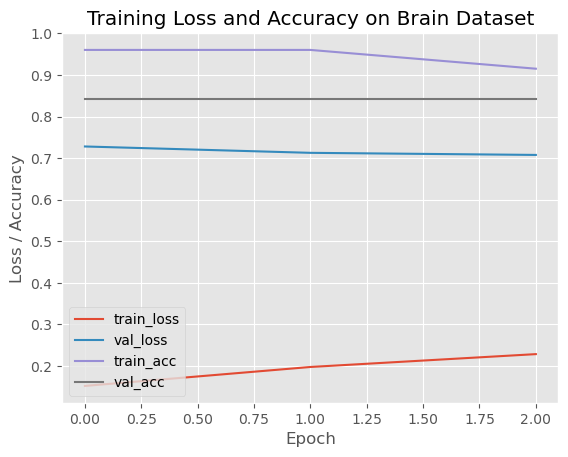

In [40]:
N = 3
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history_final.history["loss"], label= "train_loss")
plt.plot(np.arange(0, N), history_final.history["val_loss"], label= "val_loss")
plt.plot(np.arange(0, N), history_final.history["accuracy"], label= "train_acc")
plt.plot(np.arange(0, N), history_final.history["val_accuracy"], label= "val_acc")
plt.title("Training Loss and Accuracy on Brain Dataset")
plt.xlabel("Epoch")
plt.ylabel("Loss / Accuracy")
plt.legend(loc= "lower left")
plt.savefig("plot.jpg")

In [42]:
model.save("bin_model.h5")